In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_venn import venn2
from scipy.stats import spearmanr
from sklearn.isotonic import IsotonicRegression

In [3]:
from protein_conformal.util import *
from tqdm import tqdm
import glob
import os

In [3]:
import faiss

In [4]:
scope = np.load('/data/ron/protein-conformal/data/SCOPe_multidomain_embeddings_protein_vec.npy')
print(scope.shape)

# load scope metadata
_, scope_metadata = read_fasta('/data/ron/protein-conformal/data/SCOPe_multidomain.fasta')
print(len(scope_metadata))

(74, 512)
74


In [5]:
afdb = np.load('/data/ron/protein-conformal/data/afdb_embeddings_protein_vec.npy')
# load afdb metadata
_, afdb_metadata = read_fasta('/data/ron/protein-conformal/data/AFDB_sequences.fasta')
print(len(afdb_metadata))
print(afdb.shape)

2302899
(2302899, 512)


In [6]:
# remove > at the beginning of the string for scope metadata and afdb metadata
scope_metadata = [x[1:] for x in scope_metadata if x[0] == '>']
afdb_metadata = [x[1:] for x in afdb_metadata if x[0] == '>']

In [7]:
len(scope_metadata), len(afdb_metadata)

(74, 2302899)

In [8]:
np.save('/data/ron/protein-conformal/data/afdb_metadata.npy', afdb_metadata)
np.save('/data/ron/protein-conformal/data/scope_metadata.npy', scope_metadata)
# afdb_metadata = np.load('/data/ron/protein-conformal/data/afdb_metadata.npy', allow_pickle=True)
# scope_metadata = np.load('/data/ron/protein-conformal/data/scope_metadata.npy', allow_pickle=True)

In [8]:
afdb_lookup = load_database(afdb)

In [9]:
# Query for the 1st nearest neighbor
k = len(afdb_metadata)
D, I = query(afdb_lookup, scope, k)

In [10]:
I.shape, D.shape

((74, 2302899), (74, 2302899))

(array([1.000000e+00, 1.000000e+00, 0.000000e+00, 1.000000e+00,
        1.000000e+00, 4.000000e+00, 2.000000e+00, 6.000000e+00,
        1.300000e+01, 1.100000e+01, 2.300000e+01, 1.900000e+01,
        2.600000e+01, 3.400000e+01, 6.700000e+01, 1.010000e+02,
        1.130000e+02, 1.760000e+02, 2.280000e+02, 3.420000e+02,
        4.420000e+02, 6.230000e+02, 9.720000e+02, 1.217000e+03,
        1.794000e+03, 2.562000e+03, 3.513000e+03, 4.856000e+03,
        6.916000e+03, 9.390000e+03, 1.256200e+04, 1.709600e+04,
        2.277800e+04, 3.022100e+04, 4.050900e+04, 5.273600e+04,
        6.806600e+04, 8.881200e+04, 1.148830e+05, 1.439700e+05,
        1.851180e+05, 2.338420e+05, 2.871250e+05, 3.595320e+05,
        4.377260e+05, 5.418860e+05, 6.558640e+05, 7.803240e+05,
        9.449930e+05, 1.119385e+06, 1.304892e+06, 1.547301e+06,
        1.789326e+06, 2.053846e+06, 2.383457e+06, 2.705845e+06,
        3.038861e+06, 3.441623e+06, 3.865378e+06, 4.225238e+06,
        4.688865e+06, 5.149572e+06, 5.49

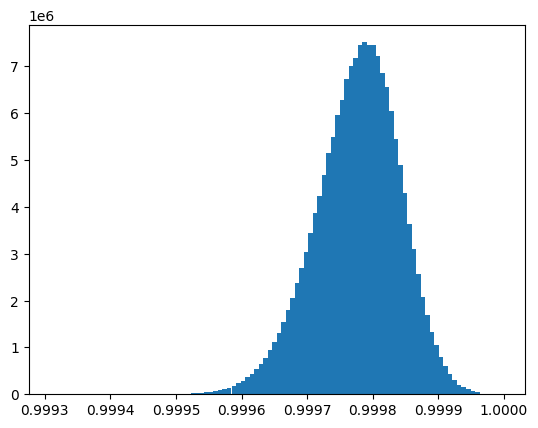

In [11]:
# plot histogram of distances
plt.hist(D.flatten(), bins=100)

## Load DALI results

In [12]:
# load all csvs into a single dataframe from /data/ron/protein-conformal/data/dali_multidomain_results_csv_small
# Get a list of all CSV files in the directory
csv_files = glob.glob('/data/ron/protein-conformal/data/dali_multidomain_results_csv_small/*.csv')

# Read each CSV file into a DataFrame and store all DataFrames in a dictionary where the key is the filename
dfs_dali = {os.path.splitext(os.path.basename(file))[0]: pd.read_csv(file) for file in csv_files}


In [13]:
# sort the dataframes by Z-score
for key in dfs_dali.keys():
    dfs_dali[key] = dfs_dali[key].sort_values(by='Z', ascending=False)

In [14]:
# Concatenate all DataFrames into a single DataFrame
df_dali = pd.concat(dfs_dali.values(), ignore_index=True)

In [20]:
results = []
for i in tqdm(range(I.shape[0])):
    metadata_model = [afdb_metadata[j] for j in I[i]]
    meta_query = scope_metadata[i]
    # get metadata of dali hits
    # metadata_dali = set(dfs_dali[meta_query]['target'].values)
    if meta_query not in dfs_dali:
        continue
    metadata_dali = dfs_dali[meta_query]['target']

    # precompute the DataFrame and create a dictionary for fast lookup
    df = dfs_dali[meta_query]
    z_score_dict = df.set_index('target')['Z'].to_dict()

    # get dali score
    dali_scores = np.zeros_like(metadata_model)
    for j, meta in enumerate(metadata_model):
        dali_scores[j] = z_score_dict.get(meta, 0)
    dali_scores = np.array(dali_scores, dtype=np.float32)

    results.append(({'meta_query': meta_query, 
                     'meta': metadata_model, 
                     'metadata_dali': list(metadata_dali), 
                     'Z_score': dali_scores, 
                     'S_i': D[i]}))

  0%|          | 0/74 [00:00<?, ?it/s]

100%|██████████| 74/74 [07:35<00:00,  6.15s/it]


In [4]:
# np.savez_compressed('/data/ron/protein-conformal/data/dali_results_protein_vec.npz', results)
results = np.load('/data/ron/protein-conformal/data/dali_results_protein_vec.npz', allow_pickle=True)

In [5]:
results = results['arr_0']

In [ ]:
results[0]

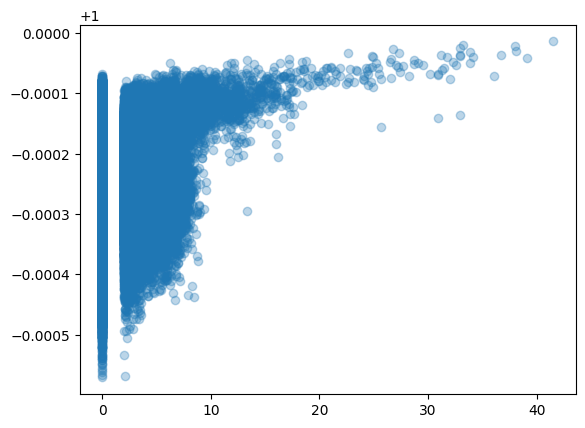

In [6]:
plt.scatter(np.array(results[0]['Z_score']), np.array(results[0]['S_i']), alpha=0.3)

In [13]:
all_z_scores = np.concatenate([x['Z_score'] for x in results])
all_s_i = np.concatenate([x['S_i'] for x in results])

normalized_z_scores = (all_z_scores - all_z_scores.min()) / (all_z_scores.max() - all_z_scores.min())
# get random indices for all_s_i and all_z_scores

# Create weights based on normalized scores (e.g., square the normalized scores to increase bias towards higher scores)
weights = normalized_z_scores ** 2.5

# Sample indices with replacement using weights
sample_size = 10000
idcs = np.random.choice(len(all_s_i), sample_size, replace=False, p=weights/weights.sum())
# idcs = np.random.choice(range(len(all_s_i)), 100000, replace=False)

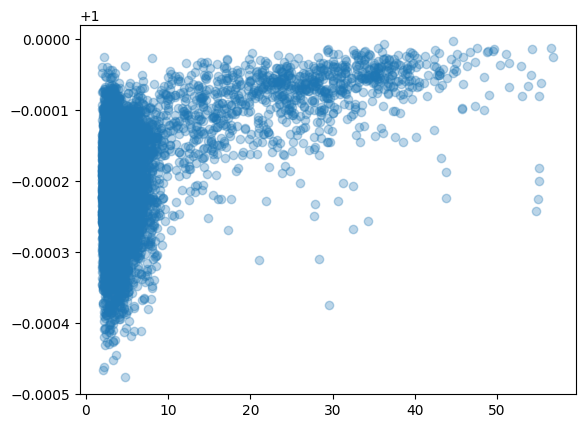

In [14]:
plt.scatter(all_z_scores[idcs], all_s_i[idcs], alpha=0.3)

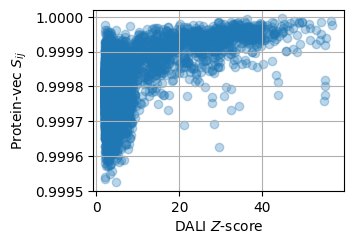

In [18]:
plt.figure(figsize=(3.5, 2.5))
plt.scatter(all_z_scores[idcs], all_s_i[idcs], alpha=0.3)
plt.grid(True)
plt.tight_layout()
# plt.xticks(rotation=45)
plt.xlabel(r'DALI $Z$-score')
plt.ylabel(r'Protein-vec $S_{ij}$')
# plt.title(r'DALI $Z$-score vs Protein-vec similarity for SCOPe proteins against clustered AFDB')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.4f}'.format(y)))
plt.savefig('/data/ron/protein-conformal/figs/afdb_new/dali_z_score_vs_protein_vec_similarity.pdf', format='pdf', bbox_inches='tight')

# spearman correlation
# print(spearmanr(results[0]['Z_score'], results[0]['S_i']))

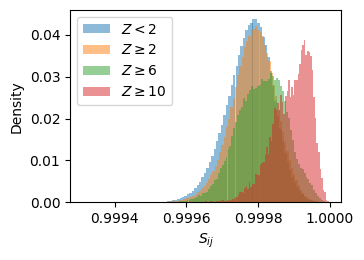

In [17]:
# Extract the first result
result = results[0]

# Ensure both Z_score and S_i are numpy arrays
# z_scores = np.array(result['Z_score'])
# s_i = np.array(result['S_i'])
z_scores = all_z_scores
s_i = all_s_i

plt.figure(figsize=(3.5, 2.5))
# plt.hist(s_i[z_scores ==0], bins=100, color='blue', alpha=0.5, label='z_scores == 0', density=True)
# # plt.hist(s_i[z_scores >2], bins=100, color='red', alpha=0.5, label='z_scores > 2')
# # plt.hist(s_i[z_scores >6], bins=100, color='yellow', alpha=0.5, label='z_scores > 6')
# plt.hist(s_i[z_scores >10], bins=100, color='green', alpha=0.5, label='z_scores > 10', density=True)
weights_0 = np.ones_like(s_i[z_scores ==0]) / len(s_i[z_scores ==0])
plt.hist(s_i[z_scores ==0], bins=100, alpha=0.5, label=r'$Z < 2$', weights=weights_0)

weights_2 = np.ones_like(s_i[z_scores >=2]) / len(s_i[z_scores >=2])
plt.hist(s_i[z_scores >=2], bins=100, alpha=0.5, label=r'$Z \geq 2$', weights=weights_2)

weights_6 = np.ones_like(s_i[z_scores >=6]) / len(s_i[z_scores >=6])
plt.hist(s_i[z_scores >=6], bins=100, alpha=0.5, label=r'$Z \geq 6$', weights=weights_6)
# label=r'$S_{ij} \geq \lambda$'

weights_10 = np.ones_like(s_i[z_scores >= 10]) / len(s_i[z_scores >=10])
plt.hist(s_i[z_scores >=10], bins=100, alpha=0.5, label=r'$Z \geq 10$', weights=weights_10)
# plt.yscale('log')
plt.legend()
# plt.xticks(rotation=45)
plt.xlabel(r'$S_{ij}$')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.4f}'.format(y)))
plt.ylabel('Density')
# plt.title(r'Histogram of Protein-vec similarity scores for different $Z$-score thresholds')
plt.savefig('/data/ron/protein-conformal/figs/afdb_new/dali_histogram_2.pdf', format='pdf', bbox_inches='tight')

In [ ]:
print(np.mean(s_i[z_scores ==0]))
print(np.mean(s_i[z_scores >0]))

0.9997545
0.99977


In [32]:
spearman_corr, p_value = spearmanr(z_scores[(z_scores != 0)], s_i[(z_scores != 0)])

In [33]:
spearman_corr, p_value

(0.006870736577610317, 0.00431871619366604)

In [24]:
def find_curve_change_point(x, y):
    """
    Finds the point of maximum curvature in the given data.

    Parameters:
    x (array-like): The x-coordinates of the data points.
    y (array-like): The y-coordinates of the data points.

    Returns:
    int: The index of the point of maximum curvature.
    """

    # Compute first and second derivatives
    first_derivative = np.gradient(y, x)
    second_derivative = np.gradient(first_derivative, x)

    # Find the index of the maximum second derivative
    curve_change_index = np.argmax(np.abs(second_derivative))

    return curve_change_index

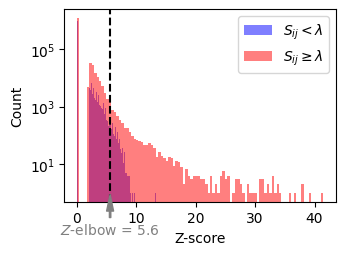

In [27]:
# lam = 0.9996087811008182

# lams = [0.99967641, 0.99983299, 0.99974871]
lam = 0.99974871
elbow_z = 5.6
plt.figure(figsize=(3.5, 2.5))
plt.hist(z_scores[s_i < lam], bins=100, color='blue', alpha=0.5, label=r'$S_{ij} < \lambda$')
plt.hist(z_scores[s_i >= lam], bins=100, color='red', alpha=0.5, label=r'$S_{ij} \geq \lambda$')
# plt.hist(z_scores[np.logical_and(s_i < lam, z_scores > elbow_z)], bins=100, color='blue', alpha=0.5, label='s_i < lam')
# plt.hist(z_scores[np.logical_and(s_i > lam, z_scores > elbow_z)], bins=100, color='red', alpha=0.5, label='s_i > lam')
# make a line at the elbow_z
plt.axvline(elbow_z, color='black', linestyle='--')
# Annotate the vertical line
plt.annotate(
    rf'$Z$-elbow = {elbow_z}', 
    xy=(elbow_z, 1), 
    xytext=(elbow_z, 0.1), 
    arrowprops=dict(facecolor='gray', edgecolor='gray', shrink=0.05, width=1, headwidth=5), 
    fontsize=10,
    color='gray',
    horizontalalignment='center', 
    # verticalalignment='bottom'
    verticalalignment='top'
)
plt.xlabel('Z-score')
plt.ylabel('Count')
plt.yscale('log')
plt.legend()
# plt.title(rf'Histogram of $Z$-scores for different Protein-vec similarity threshold $\lambda = {lam}$')
# plt.title(rf'Histogram of $Z$-scores calibrated at family-level mismatch $\alpha = {.01}$')
plt.savefig('/data/ron/protein-conformal/figs/afdb_new/histogram_z_at_thresh_new_title.pdf', format='pdf', bbox_inches='tight')
# plt.title(rf'Histogram of Z-scores for different Protein-vec similarity threshold $\lambda = ${lambda}')


In [50]:
def find_elbow_point(x, y):
    """
    Finds the elbow point in the given data.

    Parameters:
    x (array-like): The x-coordinates of the data points.
    y (array-like): The y-coordinates of the data points.

    Returns:
    int: The index of the elbow point.
    """

    # Calculate the slope of the line connecting the first and last points
    line_vector = np.array([x[-1] - x[0], y[-1] - y[0]])
    line_vector = line_vector / np.linalg.norm(line_vector)

    # Project each point onto the line
    projection = np.dot(np.vstack((x - x[0], y - y[0])).T, line_vector)
    projection = np.outer(projection, line_vector)
    proj_x = x[0] + projection[:, 0]
    proj_y = y[0] + projection[:, 1]

    # Calculate the distance from each point to the line
    distances = np.sqrt((x - proj_x) ** 2 + (y - proj_y) ** 2)

    # Find the index of the maximum distance
    elbow_index = np.argmax(distances)

    return elbow_index

In [64]:
def maximum_separation(dist_lst, first_grad, use_max_grad):
    opt = 0 if first_grad else -1
    gamma = np.append(dist_lst[1:], np.repeat(dist_lst[-1], 10))
    sep_lst = np.abs(dist_lst - np.mean(gamma))
    sep_grad = np.abs(sep_lst[:-1]-sep_lst[1:])
    if use_max_grad:
        # max separation index determined by largest grad
        max_sep_i = np.argmax(sep_grad)
    else:
        # max separation index determined by first or the last grad
        large_grads = np.where(sep_grad > np.mean(sep_grad))
        max_sep_i = large_grads[-1][opt]
    # if no large grad is found, just call first EC
    if max_sep_i >= 5:
        max_sep_i = 0
    return max_sep_i